In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch.nn.functional as F
import os
import sys

from models import RegressionLearner as Learner
from utils import random_uniform, sine_function

In [2]:
sine_function(1, 0, np.pi/6)

0.49999999999999994

In [3]:
use_gpu = False
if use_gpu:
    device = 'cuda'
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
else:
    device = 'cpu'

In [4]:
def fewShotUpdate(method, num_update, lr_a, X_input, X_observed, Y_observed):
    
    reg_learner = Learner(hidden_size=40, device=device)
    if method == 'pretrain':    
        loadpath = './trained_models/regression_pretrain.pth'
    elif method == 'maml':
        loadpath = './trained_models/regression_maml.pth'
    reg_learner.load_state_dict(torch.load(loadpath))

    mse_criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(reg_learner.parameters(), lr=lr_a*0.8)
    optimizer.zero_grad()

    reg_learner.train()

    for step in range(num_update):
        Yout = reg_learner(X_observed)
        mse_loss = mse_criterion(Yout, Y_observed)
        print(f'method: {method} | number of gradient updates:{num_update} | loss:{mse_loss}')
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()
    print('-'*100)
    # after gradient update
    reg_learner.eval()
    Y_pred = reg_learner.forward(X_input)
    y_pred = Y_pred.detach().numpy()    
   
    return y_pred

In [5]:
def showMamlSineRegression(lr_a):
    amplitude     = np.random.uniform(3, 5)
    phase     = np.random.uniform(0, np.pi)
    
    x_range = np.arange(-5, 5, 0.01)
    y_range = [sine_function(amplitude, phase, xi) for xi in x_range]
    
    # observation
    x = np.random.uniform(0.1, 4.9, size=5)
    #x = [1.5, 2.2, 3.1, 3.8, 4.5]
    # x = [1.1, 2.4, 3.0, 3.9, 4.6]
    y = [sine_function(amplitude, phase, xi) for xi in x]
    
    X_input = torch.tensor(x_range, dtype=torch.float).to(device)
    X_input = X_input.unsqueeze(-1)

    X_observed = torch.tensor(x, dtype=torch.float).to(device)
    X_observed = X_observed.unsqueeze(-1)

    Y_observed = torch.tensor(y, dtype=torch.float).to(device)
    Y_observed = Y_observed.unsqueeze(-1)
  
    
    pretrain_pred1 = fewShotUpdate(method= 'pretrain', num_update=0, lr_a=lr_a, X_input=X_input, X_observed = X_observed, Y_observed =Y_observed)
    pretrain_pred2 = fewShotUpdate(method= 'pretrain', num_update=1, lr_a=lr_a, X_input=X_input, X_observed = X_observed, Y_observed =Y_observed)
    pretrain_pred3 = fewShotUpdate(method= 'pretrain', num_update=10, lr_a=lr_a, X_input=X_input, X_observed = X_observed, Y_observed =Y_observed)
    
    maml_pred1 = fewShotUpdate(method= 'maml', num_update=0, lr_a=lr_a, X_input=X_input, X_observed = X_observed, Y_observed =Y_observed)
    maml_pred2 = fewShotUpdate(method= 'maml', num_update=1, lr_a=lr_a, X_input=X_input, X_observed = X_observed, Y_observed =Y_observed)
    maml_pred3 = fewShotUpdate(method= 'maml', num_update=10, lr_a=lr_a, X_input=X_input, X_observed = X_observed, Y_observed =Y_observed)

    
    plt.figure(figsize=(7.5,6))
    plt.title('normal pretrain')
    plt.plot(x_range, y_range, c='gray')
    plt.plot(x_range, pretrain_pred1, ls=':', c='blue', label='zero update')
    plt.plot(x_range, pretrain_pred2, ls='--', c='green', label='single update')
    plt.plot(x_range, pretrain_pred3, ls='--', c='black', label='10 updates')
    plt.scatter(x, y, c='red', s=70, marker='^')
    plt.legend()    
    plt.show()
    
    plt.figure(figsize=(7.5,6))
    plt.title('maml')
    plt.plot(x_range, y_range, c='gray')
    plt.plot(x_range, maml_pred1, ls=':', c='blue', label='zero update')
    plt.plot(x_range, maml_pred2, ls='--', c='green', label='single update')
    plt.plot(x_range, maml_pred3, ls='--', c='black', label='10 updates')
    plt.scatter(x, y, c='red', s=70, marker='^')
    plt.legend()
    plt.show()

----------------------------------------------------------------------------------------------------
method: pretrain | number of gradient updates:1 | loss:8.932758331298828
----------------------------------------------------------------------------------------------------
method: pretrain | number of gradient updates:10 | loss:8.932758331298828
method: pretrain | number of gradient updates:10 | loss:5.618224143981934
method: pretrain | number of gradient updates:10 | loss:3.1435434818267822
method: pretrain | number of gradient updates:10 | loss:2.314603090286255
method: pretrain | number of gradient updates:10 | loss:1.9958405494689941
method: pretrain | number of gradient updates:10 | loss:1.7028183937072754
method: pretrain | number of gradient updates:10 | loss:1.5049383640289307
method: pretrain | number of gradient updates:10 | loss:1.3337287902832031
method: pretrain | number of gradient updates:10 | loss:1.2026554346084595
method: pretrain | number of gradient updates:10 | lo

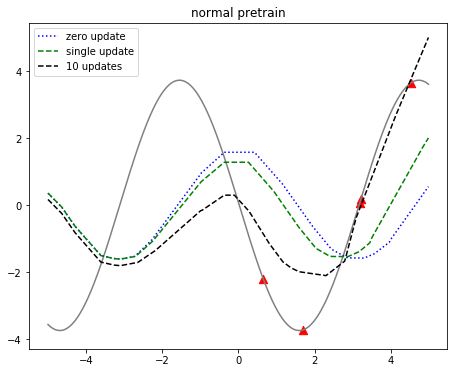

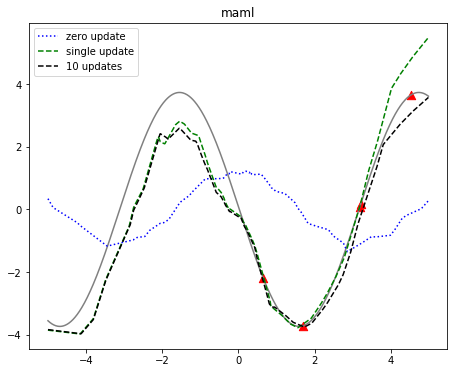

In [6]:
showMamlSineRegression(0.02)